In [1]:
import numpy as np
import matplotlib.pyplot as plt
import regex
from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree

/home/ibrahimk95/anaconda3/envs/Masterthesis/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [49]:
class Trajectory:
    '''
    Class to parse, manipulate and plot the lammps-trajectory objects.
    Takes one input argument 'file' which is the filepath of the .lammpstrj file to initialize
    - added functionality to also parse gromac trajectory .gro files.
    - TODO:: parse atom count from file instead of hardcode dummy
    - TODO:: find missing atom ... after parsing
    - TODO:: added functionality to trace molecules over time steps.
    '''

    def __init__(self, file, format='lammpstrj'):
        '''
        constructor of trajectory class
        :param file: file path to get the trajectory from
        :param format: default "lammpstrj", optional "gromac"
        '''
        self.file = file
        if format == 'lammpstrj':
            self.trajectory, self.box_dim, self.n_atoms = self.lammpstrj_to_np()
        if format == 'gromac':
           self.trajectory, self.box_dim = self.gromac_to_np()
        self.n_snapshots = len(self.box_dim)
        self.s1 = 0
        self.s2 = 0
        self.box_size = 0
        self.indexlist = 0
        self.distance = 0

    def gromac_to_np(self):
        '''
        Method to parse gromac style formated trajectories
        :param file: string giving the lammpstrj file path
        :return: returns n_dim np array with the trajectory at each snapshot and a list of the current box dimensions
        '''


        snap_count = 0
        snap_lines = []
        n_atoms = 15360     ###fix hard-code at some point

        with open(self.file) as f:
            for snap, line in enumerate(f):
                if regex.match('Generated', line.split()[0]):
                    snap_lines.append(snap + 2)
                    snap_count += 1

            atom_list = np.zeros((snap_count, n_atoms , 5))
            ind_list = [np.zeros(0) for _ in range(snap_count)]

            for i in range(snap_count):
                ind_list[i] = np.arange(snap_lines[i], snap_lines[i] + n_atoms )

        #print(ind_list)
        snap_count = 0
        line_count = 0
        box_dim = []
        with open(self.file) as f:
            for line_number, line in enumerate(f):

                if len(line.split()[:]) == 3:
                    box_dim.append(np.array([float(i) for i in line.split()[:]]))

                if any(line_number == ind_list[snap_count]):
                    if regex.match('OW1', line.split()[1]):
                        atom_list[snap_count, line_count, 1] = 1
                    if regex.match('HW2', line.split()[1]):
                        atom_list[snap_count, line_count, 1] = 2
                    if regex.match('HW3', line.split()[1]):
                        atom_list[snap_count, line_count, 1] = 2

                    atom_list[snap_count, line_count, 2:] = np.array([float(i) for i in line.split()[-3:]])
                    line_count += 1
                if line_count == n_atoms:
                    snap_count += 1
                    line_count = 0
                    print(snap_count)
                if line_number >= ind_list[-1][-1]:
                    break
        return atom_list, box_dim


    def lammpstrj_to_np(self):
        '''
        function to parse lammstrj format files to extract trajectories and return them in useable numpy data structures.
        :param file: string giving the lammpstrj file path
        :return: returns n_dim np array with the trajectory at each snapshot
        '''

        # might be usefull to know total no. of lines later on
        n_lines = sum(1 for line in open(self.file))

        ###find the number of snapshots we have and safe the corresponding line
        ###also finds the number of atoms to initialize n_dim array later
        snap_count = 0
        box_lines = 0
        snap_lines = []
        box_dim = []

        with open(self.file) as f:
            for snap, line in enumerate(f):
                if regex.match('ITEM: ATOMS id', line):
                    snap_lines.append(snap + 2)
                    snap_count += 1
                if regex.match('ITEM: NUMBER OF ATOMS', line):
                    n_atoms = int(next(f))  # this is the reason why my lines are always off by 1 -> keep an eye on unexpected behavious
                if box_lines > 0:
                    box_lines -= 1
                    box_dim.append(np.array([float(i) for i in line.split()]))
                if regex.match('ITEM: BOX BOUNDS', line):
                    box_lines = 3
            # print(snap_count, snap_lines, n_atoms)

        # transform list of box information into useful square data format.
        n_box = len(box_dim)
        temp = box_dim
        box_dim = []
        for split in range(int(n_box / 3)):
            box_dim.append(np.stack((temp[(split * 3): (split * 3 + 3)])))

        for key, line in enumerate(snap_lines):
            snap_lines[key] = line + key
        ### initialize np.arry of size (no of timesteps, no of atoms, 3d+id+species)

        atom_list = np.zeros((snap_count, n_atoms, 5))
        ind_list = [np.zeros(0) for _ in range(snap_count)]

        for i in range(snap_count):
            ind_list[i] = np.arange(snap_lines[i], snap_lines[i] + n_atoms)
        # print(ind_list)
        snap_count = 0
        line_count = 0
        with open(self.file) as f:
            for line_number, line in enumerate(f):
                #print(line_number)

                # if line_number in ind_list[snap_count]:
                if any(line_number == ind_list[snap_count]):
                    atom_list[snap_count, line_count, :] = np.array([float(i) for i in line.split()])
                    line_count += 1
                if line_count == n_atoms:
                    snap_count += 1
                    line_count = 0
                    print("Processing Snapshot:" + str(snap_count))
                if line_number >= ind_list[-1][-1]:
                    break
            '''       
            for line in f:
            pass
            print(line)
            '''
        return atom_list, box_dim, n_atoms


    def get_box_size(self):
        '''
        function to determine the actual box size given the box_dimensions extracted from the lammpstrj file
        :return: list of box_size - lengths - (x, y, z) for each snapshot.
        '''

        self.box_size = [None] * self.n_snapshots

        for i in range(self.n_snapshots):
            self.box_size[i] = abs(self.box_dim[i][:, 0] - self.box_dim[i][:, 1])
        return


    def split_species(self):
        '''
        routine to split a lammpstrj which is formated as a np.ndim array of the form (n_steps, n_particles, n_cols=5)
        into its seperate particles (assuming Water-Molecules)
        :return out_1, out_2: two output lists of 2d numpy arrays, one for each species
        '''

        n_snap, n_row, n_col = self.trajectory.shape

        out_1 = [np.zeros(0) for _ in range(n_snap)]
        out_2 = [np.zeros(0) for _ in range(n_snap)]

        for i in range(n_snap):
            out_1[i] = (self.trajectory[i, np.where(self.trajectory[i, :, 1] == 1), :]).reshape(-1, 5)
            out_2[i] = (self.trajectory[i, np.where(self.trajectory[i, :, 1] == 2), :]).reshape(-1, 5)

        return out_1, out_2

    def get_neighbour_KDT(self, species_1=None, species_2=None, mode='normal', snapshot=0):
        '''
        Routin using sklearns implementation of the KDTree datastructure for quick nearestneighbour search in O(log(n))
        compared to the naive O(N) approach
        TODO:: implement a PBC version
        :param species_1: 2D numpy array of the positions of particles from species1 (n_row, (index, species, x, y, z))
        :param species_2: 2D numpy array of the positions of particles from species2 (n_row, (index, species, x, y, z))
        :param mode: sets the handling of boundary conditions with default 'normal' meaning no boundary condition
                    optional mode ['pbc']
        :param snapshot: specifies which snapshot we are looking at, default value is 0
        :return: ind_out np.array of the nearest neighbour indices of species1 found in species2, dist_out np.array of
                the euclidean distance
        '''

        #workaround to set instance atributes as default argument
        if species_1 is None:
            species_1 = self.s1 
        if species_2 is None:
            species_2 = self.s2 
        #if species_1 or species_2 == 0:
            #raise ValueError('set self.s1 or self.s2 first or pass required arguments')
        try:
            print(species_1.shape)
            if mode == 'normal':
                tree = cKDTree(data=species_2[:, 2:] * self.box_size, leafsize=species_2.shape[0])
            if mode == 'pbc':
                tree = cKDTree(data=species_2[:, 2:] * self.box_size, leafsize=species_2.shape[0], boxsize=self.box_size[snapshot])

            n_query = species_1.shape[0]
            ind_out = np.zeros(n_query)
            dist_out = np.zeros(n_query)
            for i in range(n_query):
                dist_out[i], ind_out[i] = tree.query((species_1[i, 2:] * self.box_size).reshape(1, -1), k=1)
        except AttributeError:

            print("Atribute Error occured(recieved list instead of numpy array) using first element of list instead")
            species_1 = species_1[snapshot] 
            species_2 = species_2[snapshot] 

            if mode == 'normal':
                tree = cKDTree(data=species_2[:, 2:] * (self.box_size[snapshot]).reshape(1, -1), leafsize=species_2.shape[0])
            if mode == 'pbc':
                tree = cKDTree(data=species_2[:, 2:] * (self.box_size[snapshot]).reshape(1, -1), leafsize=species_2.shape[0], boxsize=self.box_size[snapshot])

            n_query = species_1.shape[0]
            ind_out = np.zeros(n_query)
            dist_out = np.zeros(n_query)
            for i in range(n_query):
                dist_out[i], ind_out[i] = tree.query((species_1[i, 2:]).reshape(1, -1) * (self.box_size[snapshot]).reshape(1, -1), k=1)

        return ind_out, dist_out

    def get_neighbour_naive(self, species_1=None, species_2=None, mode='normal', snapshot=0):
        '''
        Naive approach in calculating the nearest neighbour in linear time O(N) no optimizations done!
        TODO:: Implement PBC
        :param species_1: 2D numpy array of the positions of particles from species1 (n_row, (index, species, x, y, z))
        :param species_2: 2D numpy array of the positions of particles from species2 (n_row, (index, species, x, y, z))
        :param mode: sets the handling of boundary conditions with default 'normal' meaning no boundary condition
                    optional mode ['pbc']
        :param snapshot: specifies which snapshot we are looking at, default value is 0
        :return: ind_out np.array of the nearest neighbour indices of species1 found in species2, dist_out np.array of
                the euclidean distance
        '''

        def get_distance(x, y, mode='normal', img=snapshot):
            '''
            wraper for np norm function to get euclidean metric
            :param x:
            :param y:
            :param mode: sets the mode for distance calculation
            :param img: specifies the image we are looking at, used to get the correct box size for PBC
            :return:
            '''

            if mode == 'normal':
                return np.linalg.norm(x-y)
            if mode == 'pbc':
                box = self.box_size[img]
                dist = x - y

                if dist[0] > (box[0] / 2):
                    dist[0] -= box[0]
                if dist[0] <= (-box[0] / 2):
                    dist[0] += box[0]

                if dist[1] > (box[1] / 2):
                    dist[1] -= box[1]
                if dist[1] <= (-box[1] / 2):
                    dist[1] += box[1]

                if dist[2] > (box[2] / 2):
                    dist[2] -= box[2]
                if dist[2] <= (-box[2] / 2):
                    dist[2] += box[2]

                return np.sqrt(np.sum(dist**2))
            else:
                raise ValueError(f'mode {mode} unknown please use either \'normal\' or \'pbc\'')

        if species_1 is None:
            species_1 = self.s1 * self.box_size
        if species_2 is None:
            species_2 = self.s2 * self.box_size
        try:
            n_row_1 = species_1.shape[0]
            n_row_2 = species_2.shape[0]

            distance_matrix = np.zeros((n_row_1, n_row_2))
            distances = np.zeros(n_row_1)
            index = np.zeros(n_row_1, dtype='int32')

            for H in range(n_row_1):
                for O in range(n_row_2):
                    distance_matrix[H, O] = get_distance(species_1[H, 2:], species_2[O, 2:], mode)

                index[H] = np.argmin(distance_matrix[H, :])
                distances[H] = distance_matrix[H, index[H]]

        except AttributeError:

            print("Atribute Error occured(recieved list instead of numpy array) using indexed element of list instead")
            species_1 = species_1[snapshot] * self.box_size[snapshot]
            species_2 = species_2[snapshot] * self.box_size[snapshot]
            n_row_1 = species_1.shape[0]
            n_row_2 = species_2.shape[0]

            distance_matrix = np.zeros((n_row_1, n_row_2))
            distances = np.zeros(n_row_1)
            index = np.zeros(n_row_1, dtype='int32')

            for H in range(n_row_1):
                for O in range(n_row_2):
                    distance_matrix[H, O] = get_distance(species_1[H, 2:], species_2[O, 2:], mode)

                index[H] = np.argmin(distance_matrix[H, :])
                #print(index[H], H)
                distances[H] = distance_matrix[H, index[H]]

        return index, distances

    def get_water_hist(self, index_list=None):
        '''
        Quick Wraperfunction for pyplot OOP APi to draw a histogram of H-Bond distribution
        :param index_list: list of indexes for NN of the H-Atoms
        :return: Plot of the Histogram
        '''

        if index_list is None:
            index_list = self.indexlist
        #if index_list == 0:
            #raise ValueError('set self.indexlist first or pass required arguments')

        fig = plt.figure()
        ax1 = fig.add_subplot(1, 1, 1)

        ax1.yaxis.grid(alpha=0.7, linestyle="dashed", linewidth=1.5)
        ax1.set_ylabel("number of H Bonds")
        ax1.set_xlabel("index of O Atom")
        ax1.set_title("Histogram of Water Species")
        ax1.xaxis.set_ticks_position('none')
        ax1.yaxis.set_ticks_position('none')
        h, _, _ = ax1.hist(index_list, bins=np.arange(min(index_list), max(index_list) + 1, 1),
                           histtype='bar', alpha=0.8, color="purple")
        plt.show()
        plt.hist(h, bins=np.arange(min(h), max(h) + 1, 1),
                 histtype='bar', alpha=0.8, color="purple", density=True)
        plt.xlabel('number of H bonds')
        plt.ylabel('frequency')
        plt.title('Distribution of H-Bonds')
        plt.show()
        return


    def get_displace(self, snapshot = 0, id = None, distance=0.1, eps=0.01, dp_factor = 0.99):
        '''
        :param snapshot: index of the snapshot at which the displacement should happen
        :param id: id of the reference oxygen if none is given one will be picked at random
        :param distance: distance to where we want to displace to (searching for an oxygen
         particle in that radius)
        :param eps: dr at which we still accept an oxygen
        :param dp_factor: factor with which the hydrogens coordinates differ to its reference, NOTE will get replaced by
                          a collision detection method 
        :return: trajectory with one Oxygen removed and one Hydrogen displaced
        '''


        if id is None:
            id = np.random.randint(0, len(self.s2[0]))
            
            
            
        def get_distance(x, y, mode='pbc'):
            '''
            wraper for np norm function to get euclidean metric
            :param x:
            :param y:
            :param mode: sets the mode for distance calculation
            :param img: specifies the image we are looking at, used to get the correct box size for PBC
            :return:
            '''

            if mode == 'normal':
                return np.linalg.norm(x-y)
            if mode == 'pbc':
                box = [1, 1, 1] ##using scaled lammps coordinates
                dist = x - y
                #print(x, y)
                if dist[0] > (box[0] / 2):
                    dist[0] -= box[0]
                if dist[0] <= (-box[0] / 2):
                    dist[0] += box[0]

                if dist[1] > (box[1] / 2):
                    dist[1] -= box[1]
                if dist[1] <= (-box[1] / 2):
                    dist[1] += box[1]

                if dist[2] > (box[2] / 2):
                    dist[2] -= box[2]
                if dist[2] <= (-box[2] / 2):
                    dist[2] += box[2]

                return np.sqrt(np.sum(dist**2))
            else:
                raise ValueError(f'mode {mode} unknown please use either \'normal\' or \'pbc\'')
                
        def get_displaced_H(H_displace, H_pair, reference_O):
            '''
            helper function to find the coordinates of the displaced H Atom by finding the midpoint between the Bondingatoms of
            the reference O atom and then mirroring this point in space, while making sure the distance between the displaced H 
            and the reference O is smaler then the distance fo the O to its closest bonding H
            '''
        
            minimum_distance = np.min([get_distance(H_pair[0], reference_O), get_distance(H_pair[1], reference_O)])
            midpoint = (H_pair[0] + H_pair[1]) / 2
            mid_vector = midpoint - reference_O
            
            
            new_H = midpoint - 2 * mid_vector
            while (get_distance(new_H, reference_O) > minimum_distance) :
                new_H += 0.05*mid_vector
            
            return new_H
              

        traj = self.trajectory[snapshot]
        O_list = self.s2[snapshot]
        H_list = self.s1[snapshot]
        O_list = O_list[:, 2:]
        H_list = H_list[:, 2:]
        reference_O = O_list[id, :]
        reference_H = H_list[np.argwhere(self.indexlist == id).reshape(-1), :]
        distances = []


        for i in range(len(O_list)):
            temp = get_distance(reference_O, O_list[i, :])

            if (temp <= distance + eps) and (temp >= distance - eps):
                displace_H = H_list[np.argwhere(self.indexlist == i)[0], :]
                
                
                ### displace the H towards the reference O
                print("displace")
                displace_H = get_displaced_H(displace_H, reference_H, reference_O)
                
                
                #O_list = np.delete(O_list, i, axis=0) -> if we want to remove an O (not sure if we do?)
                
                #update the hydrogen list with the new displaced coordinates
                H_list[np.argwhere(self.indexlist == i)[0], :] = displace_H


                with open("water.data", "a") as input_traj:
                    input_traj.write('translated LAMMPS data file via gromacsconf\n')
                    input_traj.write('\n')
                    input_traj.write(f'       {self.n_atoms}  atoms\n')
                    input_traj.write('           2  atom types\n')
                    input_traj.write('\n')
                    input_traj.write(f'   0.00000000       {self.box_size[snapshot][0]}       xlo xhi\n')
                    input_traj.write(f'   0.00000000       {self.box_size[snapshot][1]}       ylo yhi\n')
                    input_traj.write(f'   0.00000000       {self.box_size[snapshot][2]}       zlo zhi\n')
                    input_traj.write(f'   0.00000000       0.00000000       0.00000000      xy xz yz\n')
                    input_traj.write('\n')
                    input_traj.write(' Masses\n')
                    input_traj.write('\n')
                    input_traj.write('           1   1.00794005\n')
                    input_traj.write('           2   15.9994001\n')
                    input_traj.write('\n')
                    input_traj.write(' Atoms\n')
                    input_traj.write('\n')

                    print(H_list.shape[0], O_list.shape[0])

                    for H_ind in range(H_list.shape[0]):
                        input_traj.write(f'{H_ind + 1} 1 {H_list[H_ind, 0]*self.box_size[snapshot][0]} {H_list[H_ind, 1]*self.box_size[snapshot][1]} {H_list[H_ind, 2]*self.box_size[snapshot][2]}')
                        input_traj.write('\n')
                    for O_ind in range(O_list.shape[0]):
                        input_traj.write(f'{O_ind + 1 + H_list.shape[0] + 1} 2 {O_list[O_ind, 0]*self.box_size[snapshot][0]} {O_list[O_ind, 1]*self.box_size[snapshot][1]} {O_list[O_ind, 2]*self.box_size[snapshot][2]}')
                        input_traj.write('\n')
                        

                return print("trajectory saved as water.data")


            else:
                distances.append(temp)
                print("distance too far next O")
                
 



    def group_molecules(self, timestep=5000):
        '''
        method to group nearest neighbours back to molecules to track their trajectory in time
        :return: lammpstraj file readable by common MD visualizer like ovito
        '''

        new_traj = open('grouped_water.lammpstrj', "w")
        new_traj.close()


        def write_lammpstrj(molecules, ts=timestep, snapshot=0):
            with open("grouped_water.lammpstrj", "a") as group_traj:
                group_traj.write('ITEM: TIMESTEP\n')
                group_traj.write(f'{snapshot * ts}\n')
                group_traj.write("ITEM: NUMBER OF ATOMS\n")
                group_traj.write(str(self.n_atoms)+"\n")
                group_traj.write("ITEM: BOX BOUNDS xy xz yz pp pp pp\n")
                for i in range(3):
                    temp = " ".join(map(str, self.box_dim[snapshot][i, :]))
                    group_traj.write(temp+"\n")

                group_traj.write("ITEM: ATOMS id type xs ys zs\n")

                for ind, list in enumerate(molecules):
                    if len(list) == 1:              #only O atom
                        for index in list:
                            temp = self.s2[snapshot][index, :]
                            temp[1] = 1
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                    if len(list) == 2:
                        for index in list[:-1]:     #index all the H atoms
                            temp = self.s1[snapshot][index, :]
                            temp[1] = 1
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        temp = self.s2[snapshot][list[-1], :]         #write the O atom by hand
                        temp[1] = 1
                        temp = " ".join(map(str, temp))
                        group_traj.write(temp+"\n")
                    if len(list) == 3:
                        for index in list[:-1]:
                            #print(type(index))
                            temp = self.s1[snapshot][index, :]
                            temp[1] = 1
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        temp = self.s2[snapshot][list[-1], :]
                        temp[1] = 1
                        temp = " ".join(map(str, temp))
                        group_traj.write(temp+"\n")
                    if len(list) == 4:
                        for index in list[:-1]:
                            temp = self.s1[snapshot][index, :]
                            temp[1] = 1
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        temp = self.s2[snapshot][list[-1], :]
                        temp[1] = 1
                        temp = " ".join(map(str, temp))
                        group_traj.write(temp+"\n")

                    if len(list) == 5:
                        for index in list[:-1]:
                            temp = self.s1[snapshot][index, :]
                            temp[1] = 1
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        temp = self.s2[snapshot][list[-1], :]
                        temp[1] = 1
                        temp = " ".join(map(str, temp))
                        group_traj.write(temp+"\n")
            return

        for i in range(self.n_snapshots):
            molecules = []
            indexlist_group, _ = self.get_neighbour_KDT(mode="pbc", snapshot=i)
            for O_atom in  range(self.s2[i].shape[0]):
                temp = np.append(np.argwhere(indexlist_group == O_atom), O_atom)
                molecules.append(temp)

            write_lammpstrj(molecules, timestep, i)


        return


In [50]:
file = '/home/ibrahimk95/Documents/n2p2_sims/pablo_files/293k_1/water.lammpstrj'
#file = r'C:\Users\Nutzer\Documents\Python Scripts\trjwater.lammpstrj'
#file = "water.lammpstrj"
traj = Trajectory(file)

Processing Snapshot:1
Processing Snapshot:2
Processing Snapshot:3
Processing Snapshot:4
Processing Snapshot:5
Processing Snapshot:6
Processing Snapshot:7
Processing Snapshot:8
Processing Snapshot:9
Processing Snapshot:10
Processing Snapshot:11
Processing Snapshot:12
Processing Snapshot:13
Processing Snapshot:14
Processing Snapshot:15
Processing Snapshot:16
Processing Snapshot:17
Processing Snapshot:18
Processing Snapshot:19
Processing Snapshot:20
Processing Snapshot:21
Processing Snapshot:22
Processing Snapshot:23
Processing Snapshot:24
Processing Snapshot:25
Processing Snapshot:26
Processing Snapshot:27
Processing Snapshot:28
Processing Snapshot:29
Processing Snapshot:30
Processing Snapshot:31
Processing Snapshot:32
Processing Snapshot:33
Processing Snapshot:34
Processing Snapshot:35
Processing Snapshot:36
Processing Snapshot:37
Processing Snapshot:38
Processing Snapshot:39
Processing Snapshot:40
Processing Snapshot:41
Processing Snapshot:42
Processing Snapshot:43
Processing Snapshot:

In [51]:
traj.get_box_size()

In [52]:
traj.s1, traj.s2 = traj.split_species()

In [59]:
traj.indexlist, dist_1 = traj.get_neighbour_KDT(mode='pbc', snapshot=206)


Atribute Error occured(recieved list instead of numpy array) using first element of list instead


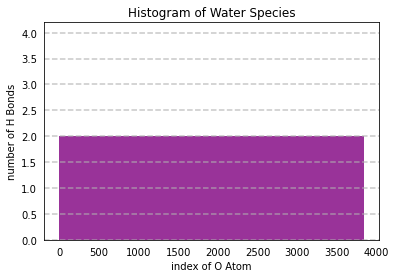

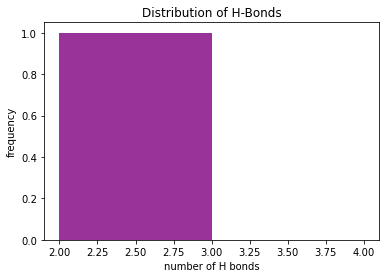

In [60]:
traj.get_water_hist(traj.indexlist)

In [55]:
np.argwhere(traj.s2[206][:, 2:] > 1)


array([], shape=(0, 2), dtype=int64)

In [61]:
traj.get_displace(snapshot=206, distance=0.3)

displace
7680 3840
trajectory saved as water.data


In [40]:
traj.s2[211][3476, 2:] 

array([0.742472, 1.00072 , 0.518592])